In [12]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

def simulate(num_wires, couplings, p, time, depth):
    
    def XX(i):
        qml.CNOT([i,(i+1)%num_wires][::-1])
        qml.RX(-2*couplings[0]*time/depth, wires=(i+1)%num_wires)
        qml.CNOT([i,(i+1)%num_wires][::-1])

    def YY(i):
        #YY
        qml.RZ(np.pi/2, wires=i)
        qml.RZ(np.pi/2, wires=(i+1)%num_wires)
        qml.CNOT([i,(i+1)%num_wires][::-1])
        qml.RX(-2*couplings[1]*time/depth, wires=(i+1)%num_wires)
        qml.CNOT([i,(i+1)%num_wires][::-1])
        qml.RZ(-np.pi/2, wires=i)
        qml.RZ(-np.pi/2, wires=(i+1)%num_wires)

    def ZZ(i):
        #ZZ
        qml.CNOT([i,(i+1)%num_wires])
        qml.RZ(-2*couplings[2]*time/depth, wires=(i+1)%num_wires)
        qml.CNOT([i,(i+1)%num_wires])

    def magnet(i):
        #magnetic field
        qml.RX(-2*couplings[3]*time/depth, wires=i)

    for j in range(depth):
        for i in range(num_wires):
            XX(i)
        for i in range(num_wires):
            YY(i)
        for i in range(num_wires):
            ZZ(i)
        for i in range(num_wires):
            magnet(i)



num_wires_list = [i for i in range(2,6)]
couplings = [1, 2, 1, 0.3]
p = 0.5
time = 1
depth = 100

print("GPU starts")

entropys = np.zeros((len(num_wires_list), depth))

for w, wires in enumerate(num_wires_list):
    print('qubits:', wires)
    dev = qml.device("lightning.qubit", wires=wires) #lightning.gpu

    @qml.qnode(dev)
    def heisenberg_trotter(init_state, couplings, p, time, depth):
        qml.QubitStateVector(init_state, wires=range(wires))
        simulate(wires, couplings, p, time, depth)
        return qml.state()

    dt = time/depth
    init_state = np.zeros(2**wires)
    init_state[0] = 1
    for n in range(depth):
        state = heisenberg_trotter(init_state, couplings, p, time=dt, depth=1)
        entropy = qml.math.vn_entropy(state, indices=[w for w in range(wires//2)])
        entropys[w,n] = entropy
        init_state = state


GPU starts
qubits: 2
qubits: 3
qubits: 4
qubits: 5


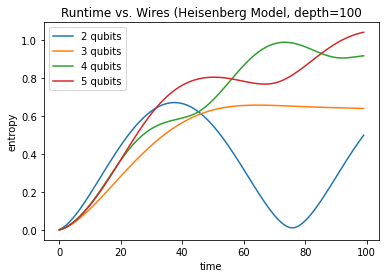

In [13]:
for w in range(len(num_wires_list)):
    plt.plot(entropys[w,:], label=f'{num_wires_list[w]} qubits')
plt.title("Runtime vs. Wires (Heisenberg Model, depth=%d" % depth)
plt.xlabel('time')
plt.ylabel('entropy')
plt.legend()